<center><h1>DSCI 552: Machine Learning for Data Science | Project</h1></center>
<br>
<br>

<center>
  <table>
    <tr>
      <th>Field</th>
      <th>Information</th>
    </tr>
    <tr>
      <td>Submitted By</td>
      <td>Parth Rohilla</td>
    </tr>
    <tr>
      <td>USC ID</td>
      <td>5207318569</td>
    </tr>
    <tr>
      <td>GitHub Username</td>
      <td>prohillaUSC</td>
    </tr>
  </table>
</center>


## Identification of Frost in Martian HiRISE Images

#### The notebook was run on Kaggle to use the TPUs for faster training and the data path of the kaggle directory is included below. The "data_head_dir" path variable needs to be changed accordingly if the notebook needs to be run outside Kaggle. Also a code snippet for TPU optimization has been added to initiate the model on TPU such that it runs efficiently as explained in https://www.kaggle.com/docs/tpu. The TPU variables and initialization would have to be removed if the notebook is run elsewhere. 

#### Import Statements 

In [1]:
import os
import sys
import random
import json
import shutil
import logging
import numpy as np
import os.path as op
from PIL import Image
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Dropout, Flatten, Dense, MaxPooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import VGG16

import warnings
warnings.filterwarnings('ignore')

#### (a) In this problem, we are trying to build a classifier that distinguishes images of Martian terrain with frost. You can find the dataset in https://dataverse.jpl.nasa.gov/dataset.xhtml?persistentId=doi:10.48577/jpl.QJ9PYA. This dataset was created to study Mars’ seasonal frost cycle and its role in the planet’s climate and surface evolution over the past 2 billion years. The data helps in identifying low-latitude frosted microclimates and their impact on climate.

In [2]:
logging.basicConfig(level=logging.INFO, datefmt='%H:%M:%S', format='%(asctime)s | %(levelname)-5s | %(module)-15s | %(message)s')
IMAGE_SIZE = (299, 299)
SEED = 42
data_head_dir = Path('/kaggle/input/project-mlds/data/data')
subdirs = [Path(subdir.stem) for subdir in data_head_dir.iterdir() if subdir.is_dir()]
src_image_ids = ['_'.join(a_path.name.split('_')[:3]) for a_path in subdirs]

In [3]:
def load_text_ids(file_path):
    """Simple helper to load all lines from a text file"""
    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f.readlines()]
    return lines

train_ids = load_text_ids('/kaggle/input/project-mlds/train_source_images.txt')
validate_ids = load_text_ids('/kaggle/input/project-mlds/val_source_images.txt')
test_ids = load_text_ids('/kaggle/input/project-mlds/test_source_images.txt')

subdir_splits = []
for src_id in src_image_ids:
    if src_id in train_ids:
        subdir_splits.append('train')
    elif src_id in validate_ids:
        subdir_splits.append('validate')
    elif(src_id in test_ids):
        subdir_splits.append('test')
    else:
        logging.warning(f'{src_id}: Did not find designated split in train/validate/test list.')
        subdir_splits.append(None)

### (b) Data Exploration and Pre-processing

### Loading and pre processing the data
i. Images (png files) and labels (json files) are organized in the data directory
by “subframes.” Subframes are individual 5120x5120 pixel images which are
crops of the original HiRISE images (often on the order of 50k x 10k pixels).
Individual subframes were annotated by the contributors and then sliced into
299x299 “tiles.” Each tile has an associated label for use in training ML
algorithms. There are 214 subframes and a total of 119920 tiles. Each tile has annotations
which have been used to assign labels to the tiles ‘frost’ or ‘background.’ Each JSON file contains all the annotation information collected from human annotators.
The following are relevant to the assignment:
Image tiles are organized into folders of ‘background’ and ‘frost’ classes (bi-
nary). For the purpose of the final project, individual tiles shall serve as the
data points which need to be classified using binary classification.

ii. The dataset includes files for splitting the data into train, test and validation.
However, you will be provided by an improved version of those files when a
repo is created:
+ train_source_images.txt
+ test_source_images.txt
+ val_source_images.txt

iii. Each of these files contains the IDs of the high rise images (parent folders for
the subframes and tiles).

In [4]:
def load_and_preprocess(img_loc, label):
    def _inner_function(img_loc, label):
        img_loc_str = img_loc.numpy().decode('utf-8')
        label_str = label.numpy().decode('utf-8')
        img = Image.open(img_loc_str).convert('RGB')
        return img, 1 if label_str=='frost' else 0
    X, y = tf.py_function(_inner_function, [img_loc, label], [tf.float32, tf.int64])
    X.set_shape((299, 299, 3))
    y.set_shape(())
    return X, y

def load_subdir_data(dir_path, image_size, seed=None):
    tile_dir = dir_path / Path('tiles')
    label_dir = dir_path /Path('labels')
    loc_list = []
    for folder in os.listdir(tile_dir):
        if os.path.isdir(os.path.join(tile_dir, folder)):
            for file in os.listdir(os.path.join(tile_dir, folder)):
                if file.endswith(".png"):
                    loc_list.append((os.path.join(os.path.join(tile_dir, folder), file), folder))
    return loc_list

## Data Augmentation Helper. The data has been enriched using random_fliping both horizontally and vertically, cropping, contrasting and random_brightness. 
def augment_image_helper(img, label):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, 0.25)
    img = tf.image.random_crop(img, size=[IMAGE_SIZE[0], IMAGE_SIZE[1], 3])
    img = tf.image.random_flip_up_down(img)
    img = tf.image.random_contrast(img, lower=0.8, upper=1.2)
    return img, label

In [5]:
tf_data_train, tf_data_test, tf_data_val = [], [], []
tf_dataset_train, tf_dataset_test, tf_dataset_val = [], [], []

buffer_size = 64
batch_size = 32

for subdir, split in zip(subdirs, subdir_splits):
    full_path = data_head_dir / subdir
    if split=='validate':
        tf_data_val.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='train':
        tf_data_train.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='test':
        tf_data_test.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))

### Generating the train/test/validation datasets for future use. Data augmentation has also been done using the augment_image_helper which increases the diversity of the training dataset, helping to reduce overfitting and improve the model's ability to generalize to new and unseen data. 

In [6]:
random.shuffle(tf_data_train)
img_list, label_list = zip(*tf_data_train)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)
tf_dataset_train = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_train = tf_dataset_train.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
# Data Augmentation done here using the augment_image_helper
tf_dataset_train = tf_dataset_train.map(lambda x, y: augment_image_helper(x, y), num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_train = tf_dataset_train.shuffle(buffer_size=buffer_size).batch(batch_size)

random.shuffle(tf_data_val)
img_list, label_list = zip(*tf_data_val)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)
tf_dataset_val = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_val = tf_dataset_val.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_val = tf_dataset_val.shuffle(buffer_size=buffer_size).batch(batch_size) 

random.shuffle(tf_data_test)
img_list, label_list = zip(*tf_data_test)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)
tf_dataset_test = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_test = tf_dataset_test.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_test = tf_dataset_test.shuffle(buffer_size=buffer_size).batch(batch_size) 

2023-12-10 16:56:55.227301: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-10 16:56:55.227411: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-10 16:56:55.227511: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-10 16:56:55.227583: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-10 16:56:55.227653: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-10 16:56:55.227878: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-10 16:56:55.227976: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority un

## (c) Training CNN + MLP
i. To perform empirical regularization, crop, randomly zoom, rotate, flip, con-
trast, and translate images in your training set for image augmentation. You
can use various tools to do this, including OpenCV.

ii. Train a three-layer CNN followed by a dense layer on the data. Choose the size of the kernels and depth of the layers and the number of neurons in the dense layer (MLP) on your own. Use ReLU’s in all of the layers. Use the softmax function, batch normalization and a dropout rate of 30%, L2 regularization, as well as ADAM optimizer. Use cross entropy loss. Train for at least 20 epochs and perform early stopping using the validation set.
Keep the network parameters that have the lowest validation error. Plot the training and validation errors vs. epochs.

iii. Report Precision, Recall, and F1 score for your model.

### I used the TPUs(Tensor Processing Units) provided by Kaggle to accelerate the training process. The TPU cluster initiation for the model was referrred from https://www.kaggle.com/docs/tpu and it helped reduce the training time massively. 

In [7]:
## detecting and initializing the TPU and Instantiating the model in the strategy scope on the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)

## Defining Model Architecture
with tpu_strategy.scope():
    model = Sequential([
        Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(299, 299, 3), kernel_regularizer=l2(0.1)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.3),
        Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.1)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.3),
        Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.2)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.3),
        Flatten(),
        Dense(128, activation='relu', kernel_regularizer=l2(0.2)),
        Dense(2, activation='softmax') 
    ])

16:56:56 | INFO  | font_manager    | generated new fontManager


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


16:56:56 | INFO  | tpu_strategy_util | Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: local


16:56:56 | INFO  | tpu_strategy_util | Initializing the TPU system: local


INFO:tensorflow:Finished initializing TPU system.


16:57:01 | INFO  | tpu_strategy_util | Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


16:57:01 | INFO  | tpu_system_metadata | Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


16:57:01 | INFO  | tpu_system_metadata | *** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


16:57:01 | INFO  | tpu_system_metadata | *** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


16:57:01 | INFO  | tpu_system_metadata | *** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


16:57:01 | INFO  | tpu_system_metadata | *** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


16:57:01 | INFO  | tpu_system_metadata | *** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


16:57:01 | INFO  | tpu_system_metadata | *** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


16:57:01 | INFO  | tpu_system_metadata | *** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


16:57:01 | INFO  | tpu_system_metadata | *** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


16:57:01 | INFO  | tpu_system_metadata | *** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


16:57:01 | INFO  | tpu_system_metadata | *** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


16:57:01 | INFO  | tpu_system_metadata | *** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


16:57:01 | INFO  | tpu_system_metadata | *** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


16:57:01 | INFO  | tpu_system_metadata | *** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)
2023-12-10 16:57:01.583310: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-10 16:57:01.583439: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


In [9]:
## Defining the early- stopping and other training relaed hyper-parameters. Training has been done for 20 epochs
## with the loss function as "sparse_categorical_crossentropy" and "val_loss" as crriteria for early stopping. 
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights = True)
model.compile(optimizer=Adam(learning_rate=0.00001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(tf_dataset_train, epochs=20, validation_data=tf_dataset_val, callbacks=[early_stopping])

2023-12-10 16:57:03.870630: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-10 16:57:03.888905: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-10 16:57:03.907156: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-10 16:57:03.925132: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-10 16:57:03.943682: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-10 16:57:03.961735: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-10 16:57:03.979567: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority un

Epoch 1/20


16:57:04 | INFO  | tpu             | TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, ((<tf.Tensor 'cond/Identity:0' shape=(None, 299, 299, 3) dtype=float32>, <tf.Tensor 'cond/Identity_8:0' shape=(None,) dtype=int64>),), {}]
16:57:06 | INFO  | tpu             | TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, ((<tf.Tensor 'cond/Identity:0' shape=(None, 299, 299, 3) dtype=float32>, <tf.Tensor 'cond/Identity_8:0' shape=(None,) dtype=int64>),), {}]
2023-12-10 16:57:07.289816: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.
2023-12-10 16:57:08.076984: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-10 16:57:08.078199: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2

  3/928 [..............................] - ETA: 1:02 - loss: 73.9357 - accuracy: 0.6146  

2023-12-10 16:57:17.655175: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-10 16:57:17.655307: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-10 16:57:17.655395: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-10 16:57:17.655483: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-10 16:57:17.655601: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-10 16:57:17.655697: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-10 16:57:17.655809: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority un

 88/928 [=>............................] - ETA: 49s - loss: 70.7339 - accuracy: 0.6065

2023-12-10 16:57:22.696742: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-10 16:57:22.696938: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


120/928 [==>...........................] - ETA: 47s - loss: 69.4842 - accuracy: 0.6151

2023-12-10 16:57:24.555725: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


174/928 [====>.........................] - ETA: 44s - loss: 67.4353 - accuracy: 0.6239

2023-12-10 16:57:27.686567: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-10 16:57:27.686767: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-10 16:57:27.686952: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


339/928 [=========>....................] - ETA: 35s - loss: 61.6468 - accuracy: 0.6349

2023-12-10 16:57:37.721610: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


928/928 [==============================] - ETA: 0s - loss: 46.5182 - accuracy: 0.6743

16:58:32 | INFO  | tpu             | TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, ((<tf.Tensor 'cond/Identity:0' shape=(None, 299, 299, 3) dtype=float32>, <tf.Tensor 'cond/Identity_8:0' shape=(None,) dtype=int64>),), {}]
2023-12-10 16:58:32.313490: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


928/928 [==============================] - 117s 112ms/step - loss: 46.5182 - accuracy: 0.6743 - val_loss: 28.1845 - val_accuracy: 0.7063
Epoch 2/20
320/928 [=========>....................] - ETA: 36s - loss: 24.8014 - accuracy: 0.7174

2023-12-10 16:59:21.000718: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


928/928 [==============================] - 76s 81ms/step - loss: 20.2490 - accuracy: 0.7322 - val_loss: 14.9413 - val_accuracy: 0.6529
Epoch 3/20
928/928 [==============================] - 76s 81ms/step - loss: 11.6331 - accuracy: 0.7627 - val_loss: 9.8372 - val_accuracy: 0.4031
Epoch 4/20
928/928 [==============================] - 76s 82ms/step - loss: 7.6991 - accuracy: 0.7915 - val_loss: 7.1972 - val_accuracy: 0.3419
Epoch 5/20
928/928 [==============================] - 76s 81ms/step - loss: 5.4425 - accuracy: 0.8204 - val_loss: 5.5098 - val_accuracy: 0.3588
Epoch 6/20
928/928 [==============================] - 76s 82ms/step - loss: 4.0892 - accuracy: 0.8411 - val_loss: 4.0148 - val_accuracy: 0.6719
Epoch 7/20
928/928 [==============================] - 76s 81ms/step - loss: 3.2784 - accuracy: 0.8592 - val_loss: 3.2769 - val_accuracy: 0.7385
Epoch 8/20
928/928 [==============================] - 77s 82ms/step - loss: 2.7692 - accuracy: 0.8758 - val_loss: 3.0363 - val_accuracy: 0.7260


## Plotting the training/validation loss vs epochs and training/validation accuracy vs epochs

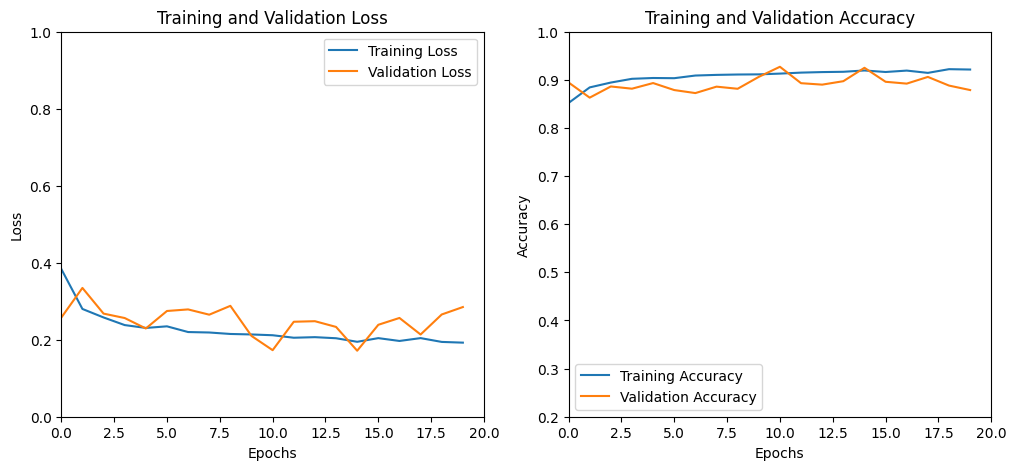

In [40]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xlim([0, 20]) 
plt.ylim([0, 1]) 
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.xlim([0, 20]) 
plt.ylim([.2, 1]) 
plt.show()

## Reporting the precision, recall and F1 score of the model for both Validation and Test Dataset

In [11]:
## Helper Method to print the classification report of the input model 
def model_evaluation_util(model, dataset, show_output=True):
  y_true = []
  y_pred = []
  for images, labels in dataset:
    predictions = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))
  report = classification_report(y_true, y_pred)
  return report

## Model evaluation on both validation and test datasets. 
validation_data_report = model_evaluation_util(model, tf_dataset_val)
test_data_report = model_evaluation_util(model, tf_dataset_test)
print(validation_data_report)
print(test_data_report)

2023-12-10 17:23:14.434073: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
17:26:53 | INFO  | tpu             | TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, (<tf.Tensor 'cond/Identity:0' shape=(None, 299, 299, 3) dtype=float32>,), {}]
2023-12-10 17:26:53.666846: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


              precision    recall  f1-score   support

           0       0.95      1.00      0.97      7654
           1       0.99      0.89      0.94      3632

    accuracy                           0.96     11286
   macro avg       0.97      0.94      0.95     11286
weighted avg       0.96      0.96      0.96     11286

              precision    recall  f1-score   support

           0       0.77      1.00      0.87      4418
           1       1.00      0.84      0.91      8405

    accuracy                           0.89     12823
   macro avg       0.88      0.92      0.89     12823
weighted avg       0.92      0.89      0.90     12823



### Hence we can see that it perfoms very well on the validation and test datasets. The Precision, Recall and F1-scores of 0.92, 0.89 and 0.90 affirms that the model is laerning to predict efficiently. 

## (d) Transfer Learning
i. When dealing with classification of relatively small image datasets, deep networks may not perform very well because of not having enough data to train
them. In such cases, one usually uses transfer learning, which uses deep
learning models that are trained on very large datasets such as ImageNet as feature extractors. The idea is that such deep networks have learned to
extract meaningful features from an image using their layers, and those features can be used in learning other tasks. In order to do that, usually the
last layer or the last few layers of the pre-trained network are removed, and the response of the layer before the removed layers to the images in the new
dataset is used as a feature vector to train one more multiple replacement
layers. In this project, you will use pre-trained models (EfficientNetB0, ResNet50 and
VGG16). For these pre-trained networks, you will only train
the last fully connected layer, and will
freeze all layers before them (i.e. we do not change their parameters during training) and use the outputs of the
penultimate layer in the original pre-trained model as the features extracted
from each image.

ii. To perform empirical regularization, crop, randomly zoom, rotate, flip, con-
trast, and translate images in your training set for image augmentation. You
can use various tools to do this, including OpenCV.

iii. Use ReLU activation functions in the last layer and a softmax layer, along
with batch normalization
and a dropout rate of 30% as well as ADAM
optimizer. Use cross entropy loss. You can try any batch size, but a batch
size of 8 seems reasonable.

iv. Train using the features calculated by networks (
EfficientNetB0, ResNet50 and
VGG16) for at least 10 epochs (preferably 20 epochs) and perform early
stopping using the validation set. Keep the network parameters that have the
lowest validation error. Plot the training and validation errors vs. epochs.

v. Report Precision, Recall, and F1 score for your model.

vi. Compare the results of transfer learning with those of CNN + MLP model
and explain them.


### <u> Transfer Learning Using EfficientNetB0

In [12]:
## Defining the model architecture on Kaggle TPU. 
with tpu_strategy.scope():    
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
    base_model.trainable = False
    x = base_model.output
    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    predictions = Dense(2, activation='softmax')(x) 
    model_efficientNet = Model(inputs=base_model.input, outputs=predictions)

16705208/16705208 [==============================] - 0s 0us/step


In [14]:
model_efficientNet.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [15]:
## Defining model hyper-parameters
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, start_from_epoch = 5 , restore_best_weights = True)
history = model_efficientNet.fit(tf_dataset_train, epochs=20, validation_data=tf_dataset_val, callbacks=[early_stopping])

Epoch 1/20


17:31:36 | INFO  | tpu             | TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, ((<tf.Tensor 'cond/Identity:0' shape=(None, 299, 299, 3) dtype=float32>, <tf.Tensor 'cond/Identity_8:0' shape=(None,) dtype=int64>),), {}]
17:31:43 | INFO  | tpu             | TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, ((<tf.Tensor 'cond/Identity:0' shape=(None, 299, 299, 3) dtype=float32>, <tf.Tensor 'cond/Identity_8:0' shape=(None,) dtype=int64>),), {}]
2023-12-10 17:31:48.370497: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


928/928 [==============================] - ETA: 0s - loss: 0.3838 - accuracy: 0.8519

17:33:20 | INFO  | tpu             | TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, ((<tf.Tensor 'cond/Identity:0' shape=(None, 299, 299, 3) dtype=float32>, <tf.Tensor 'cond/Identity_8:0' shape=(None,) dtype=int64>),), {}]
2023-12-10 17:33:22.213873: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


928/928 [==============================] - 143s 130ms/step - loss: 0.3838 - accuracy: 0.8519 - val_loss: 0.2574 - val_accuracy: 0.8946
Epoch 2/20
928/928 [==============================] - 94s 101ms/step - loss: 0.2799 - accuracy: 0.8843 - val_loss: 0.3346 - val_accuracy: 0.8630
Epoch 3/20
928/928 [==============================] - 94s 101ms/step - loss: 0.2578 - accuracy: 0.8944 - val_loss: 0.2678 - val_accuracy: 0.8862
Epoch 4/20
928/928 [==============================] - 94s 101ms/step - loss: 0.2380 - accuracy: 0.9022 - val_loss: 0.2563 - val_accuracy: 0.8816
Epoch 5/20
928/928 [==============================] - 94s 101ms/step - loss: 0.2306 - accuracy: 0.9038 - val_loss: 0.2292 - val_accuracy: 0.8933
Epoch 6/20
928/928 [==============================] - 98s 105ms/step - loss: 0.2348 - accuracy: 0.9034 - val_loss: 0.2746 - val_accuracy: 0.8788
Epoch 7/20
928/928 [==============================] - 94s 101ms/step - loss: 0.2200 - accuracy: 0.9090 - val_loss: 0.2787 - val_accuracy: 0.

## Plotting the training/validation loss vs epochs and training/validation accuracy vs epochs

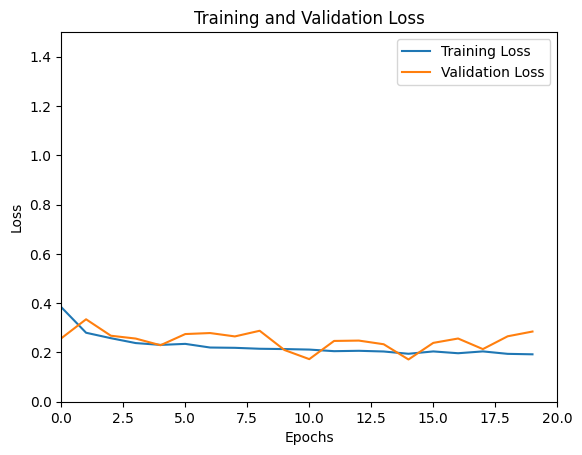

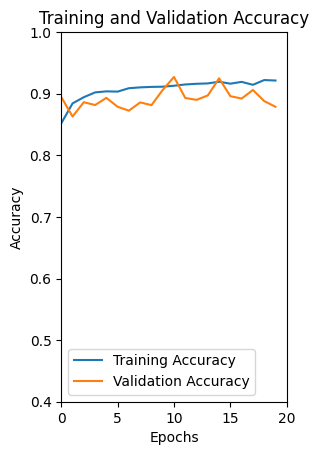

In [35]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.xlim([0, 20]) 
plt.ylim([0, 1.5]) 
plt.show()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.xlim([0, 20])
plt.ylim([0.4, 1]) 
plt.show()

## Reporting the precision, recall and F1 score of the model for both Validation and Test Dataset

In [17]:
validation_data_report = model_evaluation_util(model_efficientNet, tf_dataset_val)
test_data_report = model_evaluation_util(model_efficientNet, tf_dataset_test)
print(validation_data_report)
print(test_data_report)

2023-12-10 18:04:30.009957: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
18:08:17 | INFO  | tpu             | TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, (<tf.Tensor 'cond/Identity:0' shape=(None, 299, 299, 3) dtype=float32>,), {}]
2023-12-10 18:08:18.843692: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


              precision    recall  f1-score   support

           0       0.98      0.91      0.94      7654
           1       0.84      0.96      0.89      3632

    accuracy                           0.93     11286
   macro avg       0.91      0.93      0.92     11286
weighted avg       0.93      0.93      0.93     11286

              precision    recall  f1-score   support

           0       0.93      0.92      0.92      4418
           1       0.96      0.96      0.96      8405

    accuracy                           0.95     12823
   macro avg       0.94      0.94      0.94     12823
weighted avg       0.95      0.95      0.95     12823



### The precision, recall and f1-scores of the transfer learning model is a bit better than when training the model from CNN+MLP. Moreover it is worthwile to note that the loss from the transfer learning model converged more quickly with lesser training validating the fact that pre-trained models have learnt to extract meaningful features from an image using their layers, and those features can be used in learning other tasks. The precision, recall and F1 scores on test set are 0.95, 0.95 and 0.95 respectively. 

### <u> Transfer Learning Using RESNet

In [18]:
## Defining model architecture and hyper-parameters for training 
with tpu_strategy.scope():    
    base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
    base_model_resnet.trainable = False
    x = Flatten()(base_model_resnet.output)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    predictions_resnet = Dense(2, activation='softmax')(x)
    model_resnet = Model(inputs=base_model_resnet.input, outputs=predictions_resnet)

model_resnet.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, start_from_epoch = 5, restore_best_weights = True)
history_resnet = model_resnet.fit(tf_dataset_train, epochs=20, validation_data=tf_dataset_val, callbacks=[early_stopping])

94765736/94765736 [==============================] - 0s 0us/step
Epoch 1/20


18:13:05 | INFO  | tpu             | TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, ((<tf.Tensor 'cond/Identity:0' shape=(None, 299, 299, 3) dtype=float32>, <tf.Tensor 'cond/Identity_8:0' shape=(None,) dtype=int64>),), {}]
18:13:12 | INFO  | tpu             | TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, ((<tf.Tensor 'cond/Identity:0' shape=(None, 299, 299, 3) dtype=float32>, <tf.Tensor 'cond/Identity_8:0' shape=(None,) dtype=int64>),), {}]
2023-12-10 18:13:14.722769: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


928/928 [==============================] - ETA: 0s - loss: 0.3321 - accuracy: 0.8799

18:15:15 | INFO  | tpu             | TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, ((<tf.Tensor 'cond/Identity:0' shape=(None, 299, 299, 3) dtype=float32>, <tf.Tensor 'cond/Identity_8:0' shape=(None,) dtype=int64>),), {}]
2023-12-10 18:15:17.315370: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


928/928 [==============================] - 176s 164ms/step - loss: 0.3321 - accuracy: 0.8799 - val_loss: 0.4822 - val_accuracy: 0.8035
Epoch 2/20
928/928 [==============================] - 120s 129ms/step - loss: 0.2293 - accuracy: 0.9064 - val_loss: 0.5984 - val_accuracy: 0.8367
Epoch 3/20
928/928 [==============================] - 119s 128ms/step - loss: 0.2023 - accuracy: 0.9169 - val_loss: 0.4136 - val_accuracy: 0.8358
Epoch 4/20
928/928 [==============================] - 119s 127ms/step - loss: 0.1981 - accuracy: 0.9203 - val_loss: 0.3502 - val_accuracy: 0.8731
Epoch 5/20
928/928 [==============================] - 120s 129ms/step - loss: 0.1886 - accuracy: 0.9229 - val_loss: 0.4534 - val_accuracy: 0.8498
Epoch 6/20
928/928 [==============================] - 124s 134ms/step - loss: 0.1814 - accuracy: 0.9261 - val_loss: 0.3868 - val_accuracy: 0.8774
Epoch 7/20
928/928 [==============================] - 119s 128ms/step - loss: 0.1845 - accuracy: 0.9252 - val_loss: 0.4682 - val_accura

## Plotting the training/validation loss vs epochs and training/validation accuracy vs epochs

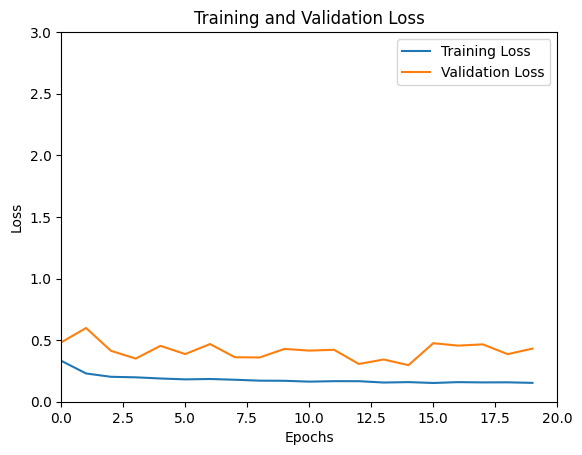

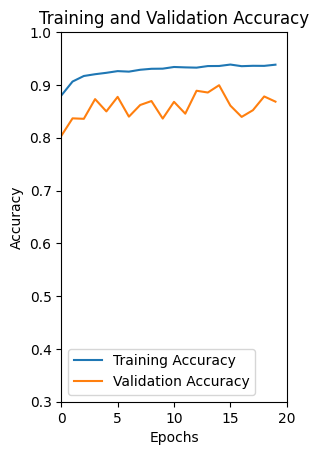

In [43]:
plt.plot(history_resnet.history['loss'], label='Training Loss')
plt.plot(history_resnet.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.xlim([0, 20]) 
plt.ylim([0, 3]) 
plt.show()

plt.subplot(1, 2, 2)
plt.plot(history_resnet.history['accuracy'], label='Training Accuracy')
plt.plot(history_resnet.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.xlim([0, 20]) 
plt.ylim([.3, 1]) 
plt.show()

## Reporting the precision, recall and F1 score of the model for both Validation and Test Dataset

In [20]:
validation_data_report = model_evaluation_util(model_resnet, tf_dataset_val)
test_data_report = model_evaluation_util(model_resnet, tf_dataset_test)
print(validation_data_report)
print(test_data_report)

2023-12-10 18:54:38.109296: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
18:58:27 | INFO  | tpu             | TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, (<tf.Tensor 'cond/Identity:0' shape=(None, 299, 299, 3) dtype=float32>,), {}]
2023-12-10 18:58:29.218697: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


              precision    recall  f1-score   support

           0       0.99      0.86      0.92      7654
           1       0.77      0.99      0.86      3632

    accuracy                           0.90     11286
   macro avg       0.88      0.92      0.89     11286
weighted avg       0.92      0.90      0.90     11286

              precision    recall  f1-score   support

           0       0.94      0.89      0.92      4418
           1       0.94      0.97      0.96      8405

    accuracy                           0.94     12823
   macro avg       0.94      0.93      0.94     12823
weighted avg       0.94      0.94      0.94     12823



### The precision, recall and F1 score on the test set is 0.94, 0.94 and 0.94 respectively. 

### <u> Transfer Learning Using VGG

In [21]:
## Defining model architecture and hyper-parameters for training. 
with tpu_strategy.scope():    
    base_model_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
    base_model_vgg.trainable = False
    x = Flatten()(base_model_vgg.output)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    predictions_vgg = Dense(2, activation='softmax')(x)
    model_vgg = Model(inputs=base_model_vgg.input, outputs=predictions_vgg)

model_vgg.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, start_from_epoch = 5, restore_best_weights = True)
history_vgg = model_vgg.fit(tf_dataset_train, epochs=20, validation_data=tf_dataset_val, callbacks=[early_stopping])

58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/20


19:02:57 | INFO  | tpu             | TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, ((<tf.Tensor 'cond/Identity:0' shape=(None, 299, 299, 3) dtype=float32>, <tf.Tensor 'cond/Identity_8:0' shape=(None,) dtype=int64>),), {}]
19:02:59 | INFO  | tpu             | TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, ((<tf.Tensor 'cond/Identity:0' shape=(None, 299, 299, 3) dtype=float32>, <tf.Tensor 'cond/Identity_8:0' shape=(None,) dtype=int64>),), {}]
2023-12-10 19:03:00.019587: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


928/928 [==============================] - ETA: 0s - loss: 0.4078 - accuracy: 0.8409

19:04:14 | INFO  | tpu             | TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, ((<tf.Tensor 'cond/Identity:0' shape=(None, 299, 299, 3) dtype=float32>, <tf.Tensor 'cond/Identity_8:0' shape=(None,) dtype=int64>),), {}]
2023-12-10 19:04:14.604707: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


928/928 [==============================] - 111s 108ms/step - loss: 0.4078 - accuracy: 0.8409 - val_loss: 0.6304 - val_accuracy: 0.7680
Epoch 2/20
928/928 [==============================] - 76s 82ms/step - loss: 0.3041 - accuracy: 0.8711 - val_loss: 0.5789 - val_accuracy: 0.7788
Epoch 3/20
928/928 [==============================] - 77s 82ms/step - loss: 0.2749 - accuracy: 0.8872 - val_loss: 0.5235 - val_accuracy: 0.7904
Epoch 4/20
928/928 [==============================] - 77s 83ms/step - loss: 0.2650 - accuracy: 0.8895 - val_loss: 0.6092 - val_accuracy: 0.7639
Epoch 5/20
928/928 [==============================] - 77s 83ms/step - loss: 0.2522 - accuracy: 0.8965 - val_loss: 0.5813 - val_accuracy: 0.7634
Epoch 6/20
928/928 [==============================] - 78s 84ms/step - loss: 0.2499 - accuracy: 0.8963 - val_loss: 0.4956 - val_accuracy: 0.8060
Epoch 7/20
928/928 [==============================] - 77s 83ms/step - loss: 0.2450 - accuracy: 0.8975 - val_loss: 0.5340 - val_accuracy: 0.7916
E

## Plotting the training/validation loss vs epochs and training/validation accuracy vs epochs

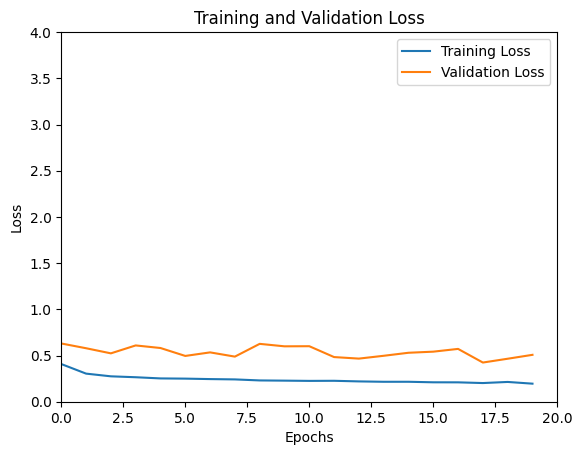

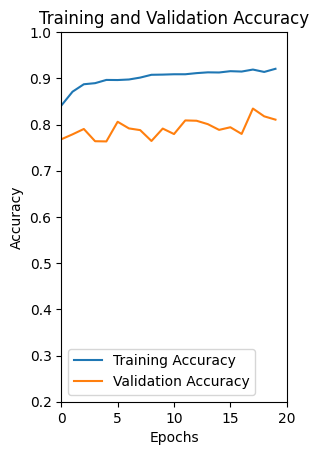

In [46]:
plt.plot(history_vgg.history['loss'], label='Training Loss')
plt.plot(history_vgg.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.xlim([0, 20])
plt.ylim([0, 4]) 
plt.show()

plt.subplot(1, 2, 2)
plt.plot(history_vgg.history['accuracy'], label='Training Accuracy')
plt.plot(history_vgg.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.xlim([0, 20])
plt.ylim([.2, 1]) 
plt.show()

## Reporting the precision, recall and F1 score of the model for both Validation and Test Dataset

In [23]:
validation_data_report = model_evaluation_util(model_vgg, tf_dataset_val)
test_data_report = model_evaluation_util(model_vgg, tf_dataset_test)
print(validation_data_report)
print(test_data_report)

2023-12-10 19:29:23.509929: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
19:33:06 | INFO  | tpu             | TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, (<tf.Tensor 'cond/Identity:0' shape=(None, 299, 299, 3) dtype=float32>,), {}]
2023-12-10 19:33:06.835832: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


              precision    recall  f1-score   support

           0       0.96      0.76      0.85      7654
           1       0.65      0.93      0.76      3632

    accuracy                           0.81     11286
   macro avg       0.80      0.84      0.80     11286
weighted avg       0.86      0.81      0.82     11286

              precision    recall  f1-score   support

           0       0.84      0.95      0.89      4418
           1       0.97      0.91      0.94      8405

    accuracy                           0.92     12823
   macro avg       0.91      0.93      0.91     12823
weighted avg       0.93      0.92      0.92     12823



### The precision, recall and f1 score on the test set is 0.93, 0.92 and 0.92 respectively. 

## vi. <u> Comparison of Results of Transfer Learning Models with those of CNN + MLP

### The evaluation metrics of the models on the TEST set has been summarized in the below table:-

<table border="1">
    <tr>
        <th></th>
        <th>Precision</th>
        <th>Recall</th>
        <th>F1 Score</th>
    </tr>
    <tr>
        <td>CNN + MLP</td>
        <td>0.92</td>
        <td>0.89</td>
        <td>0.90</td>
    </tr>
    <tr>
        <td>EfficientNet</td>
        <td>0.95</td>
        <td>0.95</td>
        <td>0.95</td>
    </tr>
    <tr>
        <td>RESNet50</td>
        <td>0.94</td>
        <td>0.94</td>
        <td>0.94</td>
    </tr>
    <tr>
        <td>VGG16</td>
        <td>0.93</td>
        <td>0.92</td>
        <td>0.92</td>
    </tr>
</table>


### We can notice that the transfer learning models perform better than the CNN + MLP model trained from scratch. This is due to the fact that the transfer learning models come with weights that have already been trained on a large diverse dataset like ImageNet. These weights contain valuable features learned from a wide variety of images, which can be effectively transferred to any other specific task like this one of classifiying the martian images. The initial layers of these models usually capture universal features (like edges and textures) which gives the model the head start in learning and allows for faster convergence. The faster convergence and reduction in loss can be seen in the graphs plotted above.

## References
+ https://www.kaggle.com/docs/tpu
+ https://keras.io/api/applications/
+ https://towardsdatascience.com/building-a-convolutional-neural-network-cnn-in-keras-329fbbadc5f5
+ https://builtin.com/data-science/transfer-learning
+ https://en.wikipedia.org/wiki/Batch_normalization
+ https://medium.com/@kenneth.ca95/a-guide-to-transfer-learning-with-keras-using-resnet50-a81a4a28084b